# Pitch Extraction

Pitch extraction is the process of finding the fundamental frequency $f_0(t)$ as a function of time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

from scipy.io import wavfile        # To read and write .wav files
from IPython.display import Audio   # To play audio in the notebook 
from ipywidgets import interact

In [2]:
# audio_file = librosa.example('trumpet') # Loading Brahms - Hungarian Dance #5 from librosa library
# sample_rate = 44100 # 44.1 kHz

In [3]:
audio_file = "./Jaydev_Vibrato_Clip.wav"
sample_rate = 22050

In [4]:
Audio(audio_file, rate = sample_rate)

### Loading audio files using `librosa.load`
Returns -
- audio: Audio numpy array
- sr: Sample rate of the file

In [5]:
audio, sample_rate = librosa.load(
    path = audio_file,
    sr = sample_rate,
    mono = True
)
print(f'Sample Rate = {sample_rate} Hz')

Sample Rate = 22050 Hz


To calculate the time duration of the audio file -
$$\text{Time Duration (in seconds)} = \frac{\text{Number of total samples in audio}}{\text{Sample Rate}}$$

In [6]:
time = len(audio)/sample_rate
print(f'Duration of the audio file = {time:.2f} s') #':.2f' limits the output to 2 decimal places

Duration of the audio file = 19.74 s


Let us plot the waveform (audio array), which we obtained from the above step

(0, 19.740952380952383)

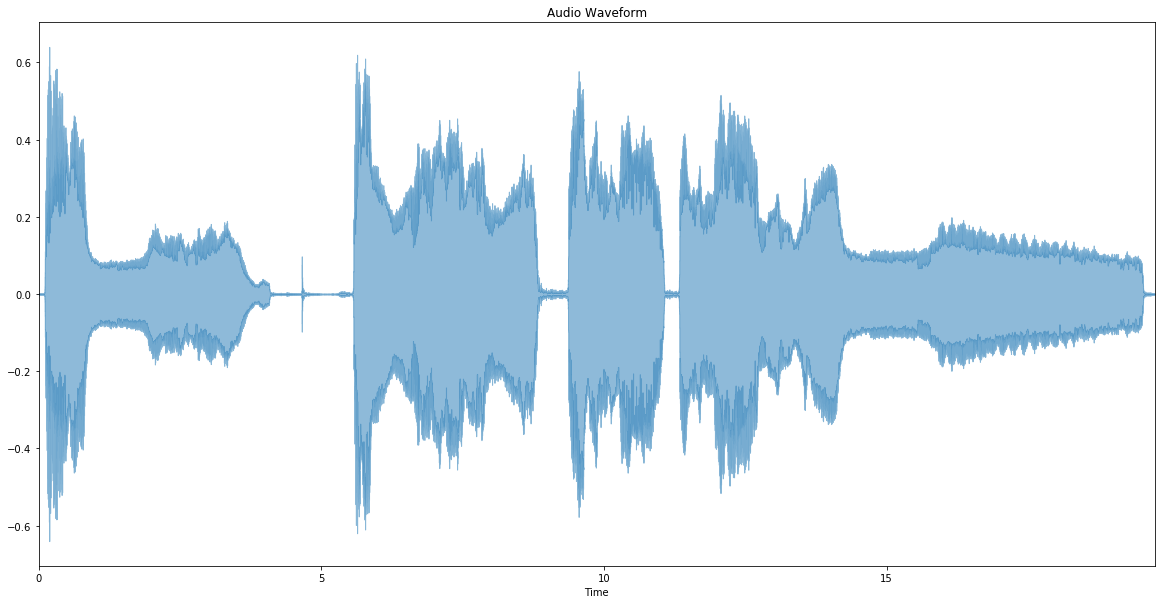

In [7]:
plt.figure(figsize = [20,10])
librosa.display.waveshow(audio, sr = sample_rate, alpha = 0.5)
# plt.plot(np.linspace(0,time,len(audio)), audio, 'k')
plt.title('Audio Waveform')
plt.xlim(0, time) # To limit the x axes between 0 and the total time

### Setting the STFT parameters

In [8]:
hop_length = sample_rate//100                               # 10 msec
win_length = hop_length * 4
n_fft = 2**(int(np.ceil(np.log2(win_length))))       # FFT size as the nearest higher power of 2

print(f"Hop Length = {hop_length}")
print(f"Window size = {win_length}")
print(f"FFT size = {n_fft}")

Hop Length = 220
Window size = 880
FFT size = 1024


In [9]:
fmin = librosa.note_to_hz('C2')
fmax = librosa.note_to_hz('C6')

## Spectrogram

In [10]:
X = librosa.stft(                               # Complex valued spectrogram
    audio,
    hop_length = hop_length,
    n_fft = n_fft,
    win_length = win_length,
    window = 'blackman'
)

In [11]:
mX = np.abs(X)                                  # Magnitude Spectrogram
mX = librosa.amplitude_to_db(mX, ref=np.max)    # To convert to dB scale
pX = np.angle(X)                                # Phase Spectrogram

Text(0.5, 1.0, 'Magnitude Spectrogram')

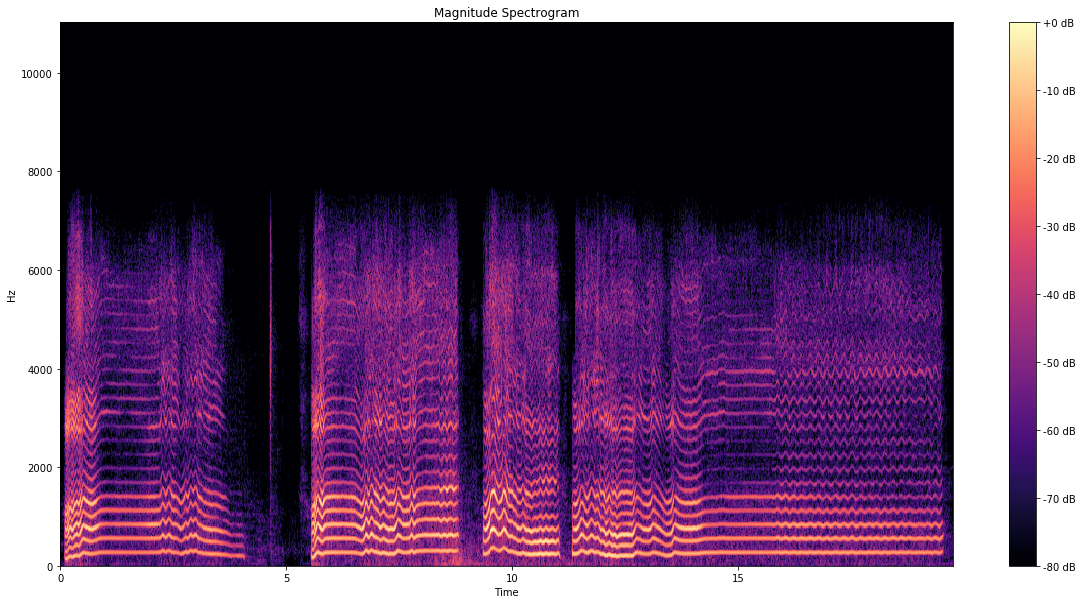

In [12]:
plt.figure(figsize=(20,10))
img = librosa.display.specshow(mX, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(img, format="%+2.f dB")
plt.title('Magnitude Spectrogram')

# Probabilistic YIN algorithm using `librosa.pyin`
Documentation: https://librosa.org/doc/0.8.1/generated/librosa.pyin.html

In [13]:
f0, voiced_flag, voiced_probs = librosa.pyin(
    y = audio,
    fmin=librosa.note_to_hz('C2'),
    fmax=librosa.note_to_hz('C7'),
    sr = sample_rate,

    # STFT parameters for spectrogram
    hop_length = hop_length,
    win_length = win_length,
    frame_length = n_fft,
    fill_na = 0             # Default is np.nan, if kept as np.nan, saving the sine audio file later will encounter issues
)
times = librosa.times_like(f0, sr = sample_rate, hop_length = hop_length, n_fft = n_fft)

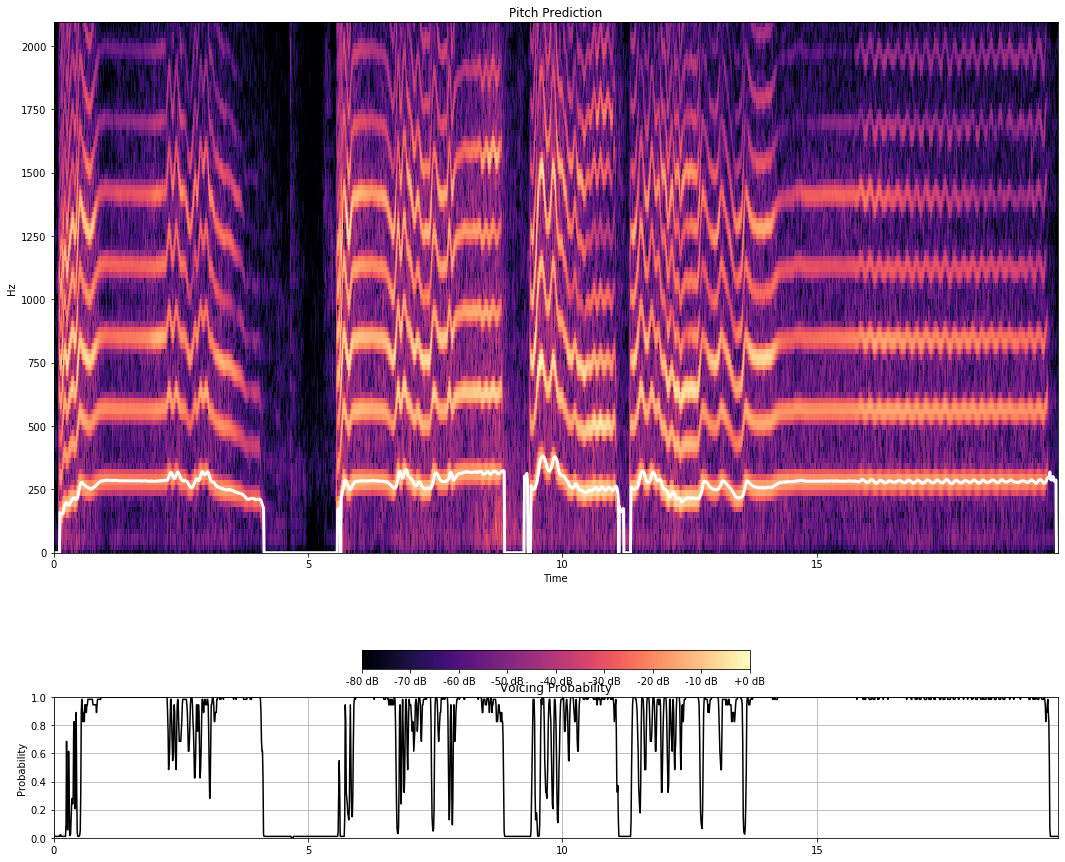

In [14]:
fig = plt.figure(2, figsize = [18,15])
ax = fig.add_gridspec(5, 5)

ax1 = plt.subplot(ax[0:4, :])
img = librosa.display.specshow(mX, sr=sample_rate, hop_length=hop_length, x_axis='time',y_axis='linear')
# plt.colorbar(img, format="%+2.f dB")
plt.ylim(0, fmax*2) # Setting y axis limits
plt.xlim(0, time)
plt.plot(times, f0, 'w', linewidth = 3)
plt.title('Pitch Prediction')
plt.colorbar(img, orientation="horizontal",fraction=0.03,anchor=(0.5,-1), format = "%+2.f dB")

# Probabilities
ax2 = plt.subplot(ax[4, :], sharex = ax1)
plt.plot(times, voiced_probs, 'k')
plt.xlim(0, time)
plt.ylabel('Probability')
plt.ylim(0,1)
plt.title('Voicing Probability')
plt.grid()

In [15]:
Audio(audio_file)

## Post-Processing

### 1. Gap filling
Sometimes, the algorithm does not predict the correct presence of pitches for very short durations. Hence we shall fill the gaps < 250 ms

In [16]:
count = 0
gap_time = 0.25/(hop_length/sample_rate) # 250 ms
value = 0
f0_new = f0
for i in range(len(f0)):
    if(f0[i]==0):
        count+=1
    else:
        if(count>=gap_time):
            count = 0
        else:
            f0_new[i-count:i] = np.ones(count)*value
            count = 0
            value = 0
    if(i!=len(f0)-1 and f0[i+1]==0 and count==0):
        value = f0[i]
f0 = f0_new

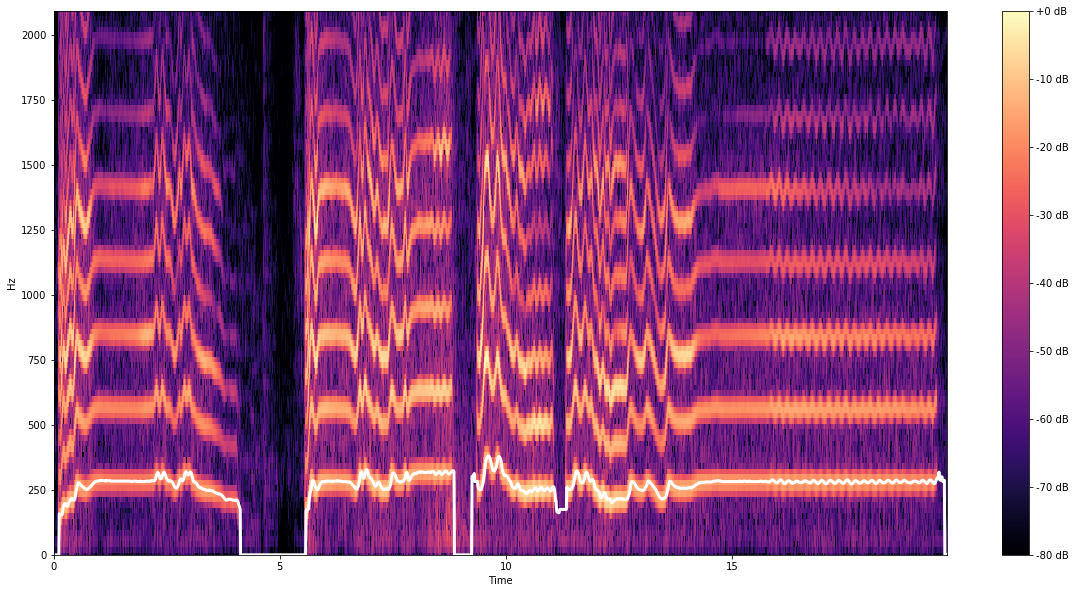

In [17]:
plt.figure(figsize = [20,10])
img = librosa.display.specshow(mX, sr=sample_rate, hop_length=hop_length, x_axis='time',y_axis='linear')
plt.colorbar(img, format="%+2.f dB")
plt.ylim(0, fmax*2)
plt.plot(times, f0_new, 'w', linewidth = 3)

### 2. Gaussian Smoothing
E.g. If in a time-series data, the number of new cases on October 27, 2020 is 570 whereas the day before, the new cases were 1741 and the day after, the new cases were 1954. It is highly unlikely 570 is the true number of new cases on that day. Here Gaussian smoothing solves the problem.

Gaussian Kernel -
$$K(x^*,x_i) = \exp \bigg(-\frac{(x^*-x_i)^2}{2\sigma^2}\bigg)$$


The $\sigma$ value, the **standard deviation** can be understood as taking the average of $±\sigma$ days average. **Larger** the $\sigma$, **smoother** the graph.

We shall use the `scipy` package to perform Gaussian Smoothing

In [18]:
from scipy.ndimage import gaussian_filter1d
sigma = 0.5
f0_GS = gaussian_filter1d(f0_new, sigma)

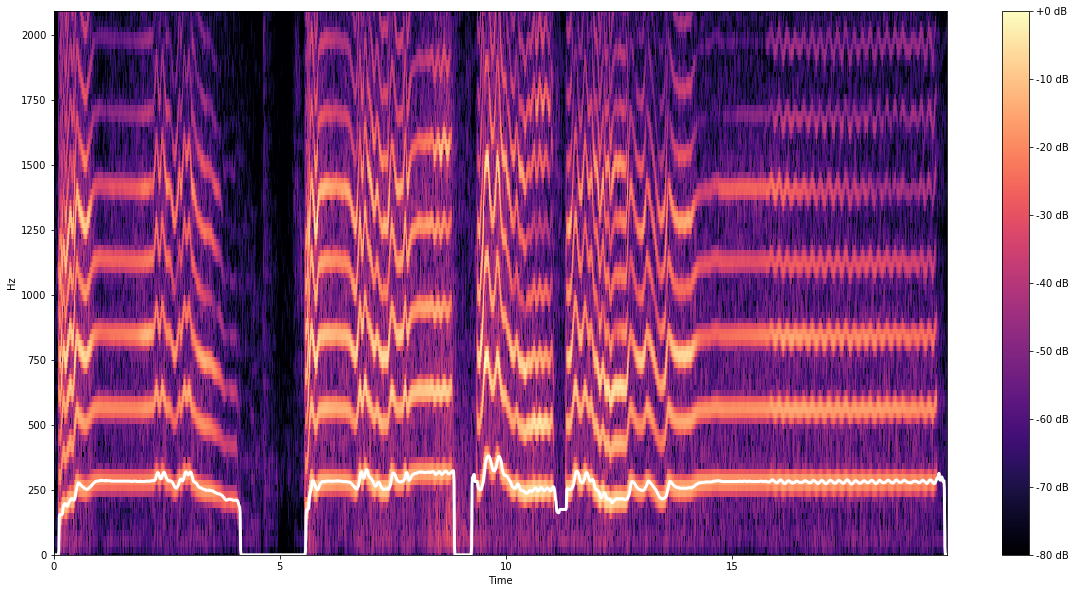

In [19]:
plt.figure(figsize = [20,10])
img = librosa.display.specshow(mX, sr=sample_rate, hop_length=hop_length, x_axis='time',y_axis='linear')
plt.colorbar(img, format="%+2.f dB")
plt.ylim(0, fmax*2)
plt.plot(times, f0_GS, 'w', linewidth = 3)

#### Check how value of sigma ($\sigma$) affects the graph

In [20]:
def gaussian_smoothing(sigma=0.5):
    f0_GS_interactive = gaussian_filter1d(f0_new, sigma)
    plt.figure(figsize = [20,10])
    img = librosa.display.specshow(mX, sr=sample_rate, hop_length=hop_length, x_axis='time',y_axis='linear')
    plt.colorbar(img, format="%+2.f dB")
    plt.ylim(0, fmax*2)
    plt.plot(times, f0_GS_interactive, 'w', linewidth = 3)
    plt.title(f'Pitch Prediction ($\sigma$ = {sigma})')

In [21]:
interact(gaussian_smoothing, sigma = (0.5, 10.0, 0.5))

interactive(children=(FloatSlider(value=0.5, description='sigma', max=10.0, min=0.5, step=0.5), Output()), _do…

<function __main__.gaussian_smoothing(sigma=0.5)>

As one increases the sigma ($\sigma$) value, the pitch gets smoother, and more information on the attacks and pitch is lost. At the same time, they help in reducing sudden peaks predicted by the algorithm. Hence, an optimal sigma ($\sigma$) value needs to be chosen.

## Synthesizing a sine wave from the $f_0(t)$

### Root Mean Squared (RMS) Energy
We shall calculate the RMS energy as a function of time and use it as the amplitudes for the sine wave sythesis. RMS energy is calculated *frame-wise* as follows -

$$\text{RMS}_t = \sqrt{\frac{1}{K}.\sum_{k=t.K}^{[(t+1).K]-1}s(k)^2}$$

where - 
- $t$: Frame number
- $K$: Number of samples in **one** frame
- $s(k)$: Amplitude of the $k^{th}$ sample => $s(k)^2$: Energy of the $k^{th}$ sample

RMS Energy is the general indicator of **loudness** of the audio as a function of time.

In [22]:
def rms_energy(signal, frame_length, hop_length):
    return np.array([np.sqrt(np.sum(signal[i:i+frame_length]**2)/frame_length) for i in range(0, len(signal), hop_length)])

In [23]:
rms_en = rms_energy(audio, frame_length = n_fft, hop_length = hop_length)

(0, 19.740952380952383)

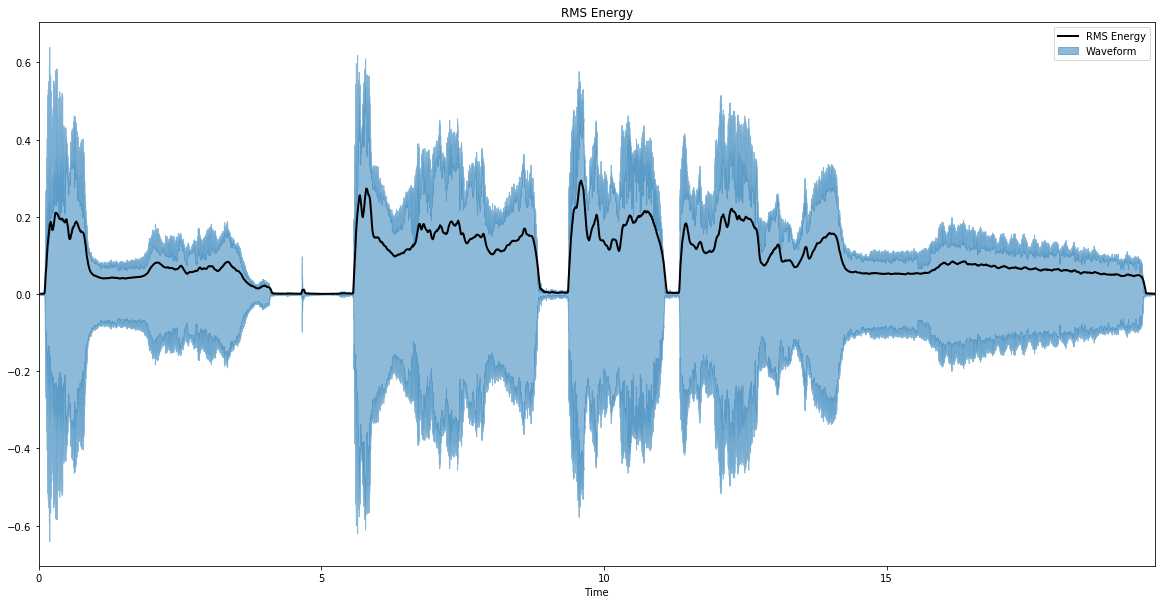

In [24]:
plt.figure(figsize = [20,10])
librosa.display.waveshow(audio, sr = sample_rate, alpha = 0.5, label = 'Waveform')
plt.plot(np.linspace(0 + n_fft/sample_rate, time + n_fft/sample_rate, len(rms_en)), rms_en, 'k', linewidth = 2, label = 'RMS Energy')
plt.title('RMS Energy')
plt.legend()
plt.xlim(0, time) # To limit the x axes between 0 and the total time

Calculating the RMS energy with the **same** frame length and hop size as calculated for $f_0$

In [25]:
rms_en_f0 = rms_energy(audio, frame_length = n_fft, hop_length = hop_length)

### Final sine wave synthesis
Defining the `sineWaveSynth` function to synthesize the sine wave, given the $f_0(t)$ and $\text{amplitude}(t)$. 

**This piece of code is used from MTG/sms-tools**

In [26]:
def sinewaveSynth(freqs, amp, H, fs):
	"""
	Synthesis of one sinusoid with time-varying frequency
	freqs, amps: array of frequencies and amplitudes of sinusoids
	H: hop size, 
	fs: sampling rate
	returns y: output array sound
	"""

	t = np.arange(H)/float(fs)                              		# time array
	lastphase = 0                                           		# initialize synthesis phase
	lastfreq = freqs[0]                                     		# initialize synthesis frequency
	y = np.array([])                                        		# initialize output array
# 	print(freqs.size, H)
	for l in range(freqs.size):                             		# iterate over all frames
		if ((lastfreq==0) and (freqs[l]==0)):                     	# if 0 freq add zeros
			A = np.zeros(H)
			freq1 = np.zeros(H)
		elif ((lastfreq==0) and (freqs[l]>0)):                    	# if starting freq ramp up the amplitude
			A = np.arange(0, amp[l], amp[l]/H)
			freq1 = np.ones(H)*freqs[l]
		elif ((lastfreq>0) and (freqs[l]>0)):                     	# if freqs in boundaries use both
			A = np.ones(H)*amp[l]
			if (lastfreq==freqs[l]):
				freq1 = np.ones(H)*lastfreq
			else:
				freq1 = np.arange(lastfreq, freqs[l], (freqs[l]-lastfreq)/H)
		elif ((lastfreq>0) and (freqs[l]==0)):                    	# if ending freq ramp down the amplitude
			A = np.arange(amp[l],0,-amp[l]/H)
			freq1 = np.ones(H)*lastfreq
		else:
			freq1 = np.zeros(H)
			A = np.zeros(H)
		if freq1.size > t.size:
			freq1 = freq1[:t.size]
		phase = 2*np.pi*freq1*t+lastphase                      		# generate phase values
		if A.shape != H:
			A = A[:H]
# 			print(l, A.shape, phase.shape, lastfreq, freqs[l], amp[l], A[0], A[-1], A[-2])
		yh = A * np.cos(phase) 		                           		# compute sine for one frame
		lastfreq = freqs[l]                                   		# save frequency for phase propagation
		lastphase = np.remainder(phase[H-1], 2*np.pi)         		# save phase to be use for next frame
		y = np.append(y, yh)                                  		# append frame to previous one
	return y

In [27]:
output = sinewaveSynth(freqs = np.array(f0_GS), amp = rms_en_f0, H = hop_length, fs = sample_rate)
Audio(output, rate = sample_rate)

Original audio for comparison

In [28]:
Audio(audio_file)